In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import joblib

In [2]:
data = pd.read_csv("../data/region_stats.txt", sep='\t')
orig_sources = ['baylor', 'giab', 'pacbio', 'ucsd1', 'ucsd2']
data.head()

,count,mean,std,min,25%,50%,75%,max,tot_len,total,removed,removed_pct,chrom_rm,small_rm,big_rm,coord_rm,span_total,span_rm,span_kept,source
0,965511.0,330.0,6599.0,25.0,35.0,47.0,87.0,500000.0,319296434.0,652237.0,100.0,0.015332,0.0,0.0,100.0,0.0,138453831.0,64064615.0,74389216.0,baylor
1,1852129.0,159.0,4818.0,1.0,22.0,43.0,77.0,2282171.0,294579269.0,1400092.0,130507.0,9.321316,0.0,130321.0,186.0,0.0,165371166.0,36031954.0,129339212.0,giab
2,171146.0,26.0,12.0,4.0,18.0,24.0,34.0,532.0,4538741.0,171145.0,7790.0,4.551696,0.0,7790.0,0.0,0.0,4538738.0,56923.0,4481815.0,pacbio
3,1776010.0,20.0,11.0,2.0,12.0,16.0,24.0,399.0,35852305.0,1739897.0,1646.0,0.094603,0.0,1646.0,0.0,0.0,35311586.0,10765.0,35300821.0,ucsd1
4,10264.0,59.0,27.0,20.0,38.0,52.0,73.0,284.0,613138.0,10259.0,0.0,0.000000,0.0,0.0,0.0,0.0,612921.0,0.0,612921.0,ucsd2


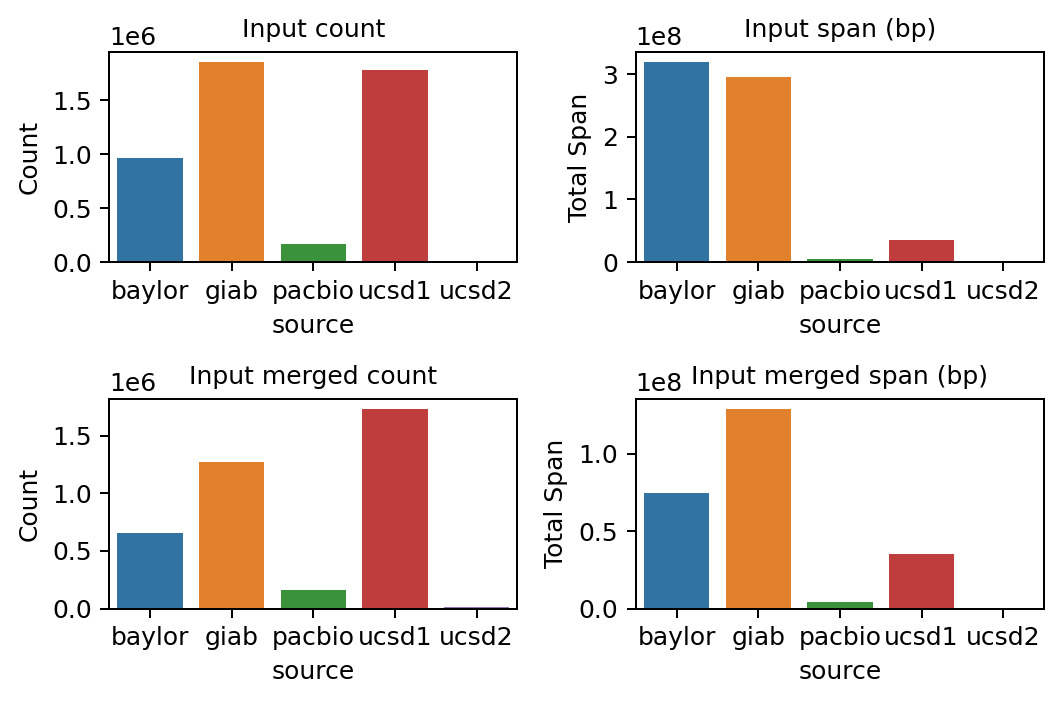

In [3]:
# Input bed files' stats
m_fontsz = 10
fix, axs = plt.subplots(2, 2, dpi=180)

plt.sca(axs[0][0])
p = sb.barplot(data=data, x="source", y="count", order=orig_sources)
p.set_title("Input count", fontsize=m_fontsz)
hide = p.set(ylabel="Count")

plt.sca(axs[0][1])
p = sb.barplot(data=data, x="source", y="tot_len", order=orig_sources)
p.set_title("Input span (bp)", fontsize=m_fontsz)
hide = p.set(ylabel="Total Span")

# Input merged bed files' stats
plt.sca(axs[1][0])
data['kept_count'] = data['total'] - data['removed']
p = sb.barplot(data=data, x="source", y="kept_count", order=orig_sources)
p.set_title("Input merged count", fontsize=m_fontsz)
hide = p.set(ylabel="Count")

plt.sca(axs[1][1])
# Input bed files' stats
p = sb.barplot(data=data, x="source", y="span_kept", order=orig_sources)
p.set_title("Input merged span (bp)", fontsize=m_fontsz)
hide = p.set(ylabel="Total Span")

plt.tight_layout()

In [4]:
# Input bed files stats table
data[data["source"].isin(orig_sources)][["source", 'count', 'tot_len', 'kept_count', 'span_kept']]

,source,count,tot_len,kept_count,span_kept
0,baylor,965511.0,319296434.0,652137.0,74389216.0
1,giab,1852129.0,294579269.0,1269585.0,129339212.0
2,pacbio,171146.0,4538741.0,163355.0,4481815.0
3,ucsd1,1776010.0,35852305.0,1738251.0,35300821.0
4,ucsd2,10264.0,613138.0,10259.0,612921.0


In [5]:
#Input sources merged stats
data[data["source"]=="grand"][["count", "tot_len"]]

,count,tot_len
5,3833587.0,244123985.0


In [6]:
# filtering (gaps) of the grand unified bed (a.k.a. the final)
data[data['source'] == 'final'][["count", "tot_len"]]

,count,tot_len
8,2232565.0,238052458.0


# TRF annotations

In [7]:
regions = pd.read_csv("../data/tr_regions.bed.gz", sep='\t', names=["chrom", "start", "end"])
annos = joblib.load("../data/tr_annotated.jl")
annos['key'] = annos.apply((lambda x: f"{x['chrom']}:{x['in_region_start']}-{x['in_region_end']}"), axis=1)

In [68]:
region_count = len(regions)
anno_count = len(annos['key'].unique())
print(f"We have a total of {region_count} regions")
print(f"We annotated {anno_count} regions")
print(f"With a total of {len(annos)} annotations...")
total_anno_span = (annos["end"] - annos["start"]).sum()
print(f"... spanning {total_anno_span}bp")
print("Annotation percent %.2f%%" % (anno_count / region_count * 100))

We have a total of 2232565 regions
We annotated 1793027 regions
With a total of 3298925 annotations...
... spanning 191486115bp
Annotation percent 80.31%


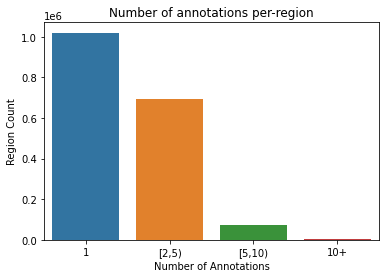

In [66]:
# Number of annotations per-regions

annos_per_region = annos.groupby('key').size()
labels = ["1", "[2,5)", "[5,10)", "10+"]
bins = pd.cut(annos_per_region, bins=[1, 2, 5, 10, 200], labels=labels, right=False )
view = pd.concat([annos_per_region, bins], axis=1)
view.columns = ["Count", "Bin"]
p = sb.countplot(data=view, x="Bin")
hide = p.set(title="Number of annotations per-region", xlabel="Number of Annotations", ylabel="Region Count")

In [25]:
regions_with_gt1 = (annos.groupby('key').size() > 1).sum()
print(f"We have {regions_with_gt1} regions with more than one TRF entry")

We have 773181 regions with more than one TRF entry


# Source to regions summary
How many of the source's merged.bed regions hit the tr_regions.bed

In [30]:
inter = joblib.load("../data/intersection.jl")

In [50]:
# Counts of intersection
summary_of_intersection = inter[inter['intersection'] != 0].groupby(['source', 'ro'])['count'].sum().unstack()

In [51]:
input_counts = data[['source', 'kept_count']].copy().set_index("source")
input_counts.columns = ['input_count']
summary_of_intersection = summary_of_intersection.join(input_counts, how='left')
summary_of_intersection.columns = ['in_tr_regions', 'in_tr_regions (50%ro)', 'input_count']

summary_of_intersection['pct_in'] = summary_of_intersection['in_tr_regions'] / summary_of_intersection['input_count']
summary_of_intersection['pct_in(50)'] = summary_of_intersection['in_tr_regions (50%ro)'] / summary_of_intersection['input_count']
summary_of_intersection

,in_tr_regions,in_tr_regions (50%ro),input_count,pct_in,pct_in(50)
source,,,,,
baylor,648439,628584,652137.0,0.994329,0.963883
giab,1072188,841403,1269585.0,0.844518,0.662739
pacbio,159535,130816,163355.0,0.976615,0.800808
ucsd1,1386733,1225317,1738251.0,0.797775,0.704914
ucsd2,10173,9811,10259.0,0.991617,0.956331


In [49]:
# And I want to do this again but with the annotated hits.
# This is harder because merged vs unmerged...

In [ ]:
# Separate out regions that don't have annotations
# I'd lke to 